In [496]:
import pandas as pd
import numpy as np
import scikitplot as skplt
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss

#import matplotlib

In [497]:
def logreg_auc(variables, target, basetable):
    X = basetable[variables]
    y = basetable[target].values.ravel()
    logreg = linear_model.LogisticRegression(solver='lbfgs', max_iter = 200)
    logreg.fit(X, y)
    predictions = logreg.predict_proba(X)[:,1]
    auc = roc_auc_score(y, predictions)
    return(auc)

def logreg_ll(variables, target, basetable):
    X = basetable[variables]
    y = basetable[target].values.ravel()
    logreg = linear_model.LogisticRegression(solver='lbfgs', max_iter = 200)
    logreg.fit(X, y)
    predictions = logreg.predict_proba(X)[:,1]
    ll = log_loss(y, predictions)
    return(ll)

def next_best(current_variables,candidate_variables, target, basetable):
    best_auc = -1
    best_ll = 100000
    best_variable = None
    for v in candidate_variables:
        #auc_v = logreg_auc(current_variables + [v], target, basetable)
        ll_v = logreg_ll(current_variables + [v], target, basetable)
        #if auc_v >= best_auc:
        #    best_auc = auc_v
        if ll_v <= best_ll:
            best_ll = ll_v
            best_variable = v
    print(best_ll)
    return best_variable

In [498]:
def create_pig_table(basetable, target, variable):
  
    # Create groups for each variable
    groups = basetable[[target,variable]].groupby(variable)
                                   
    # Calculate size and target incidence for each group
    #def my_agg(x):
    #    names = {
    #        'Incidence': x[target].mean(),
    #        'Size':  x[target].count()}
    #    return pd.Series(names, index=['Incidence', 'Size'])
    
    #groups.groupby(target).apply(my_agg)
    pig_table = groups[target].agg({'Incidence' : np.mean, 'Size' : np.size}).reset_index()
    
    # Return the predictor insight graph table
    return pig_table

def plot_pig(pig_table,variable):
    
    # Plot formatting
    plt.ylabel("Size", rotation = 0,rotation_mode="anchor", ha = "right" )
    
    # Plot the bars with sizes 
    pig_table["Size"].plot(kind="bar", width = 0.5, color = "lightgray", edgecolor = "none") 
    
    # Plot the incidence line on secondary axis
    pig_table["Incidence"].plot(secondary_y = True)
    
    # Plot formatting
    plt.xticks(np.arange(len(pig_table)), pig_table[variable])
    plt.xlim([-0.5, len(pig_table)-0.5])
    plt.ylabel("Incidence", rotation = 0, rotation_mode="anchor", ha = "left")
    
    # Show the graph
    plt.show()
    

In [499]:
data = pd.read_csv("data/data_002.csv")

In [500]:
data.head()

,Unnamed: 0,YEAR,SERIAL,DUID,PID,MEPSID,PANEL,PSUANN,STRATANN,PSUPLD,...,HEARTATTEV,HEARTCONEV,HYPERTENEV,STROKEAGE,STROKEV,HYPERTENAGE,CHEARTDIAGE,HEARTATTAGE,CHOLHIGHAGE,DIABETICAGE
0,1,2010,1,10007,101,1000710115,15,2,1024,2.0,...,1,1,2,0,1,24,96,96,27,96
1,2,2010,1,10007,102,1000710215,15,2,1024,2.0,...,1,1,1,0,1,96,96,96,96,96
2,3,2010,1,10007,103,1000710315,15,2,1024,2.0,...,0,0,0,0,0,96,96,96,96,96
3,4,2010,1,10007,104,1000710415,15,2,1024,2.0,...,0,0,0,0,0,96,96,96,96,96
4,5,2010,2,10008,101,1000810115,15,1,1021,1.0,...,1,1,1,0,1,96,96,96,96,96


In [501]:
data.dtypes

Unnamed: 0       int64
YEAR             int64
SERIAL           int64
DUID             int64
PID              int64
MEPSID           int64
PANEL            int64
PSUANN           int64
STRATANN         int64
PSUPLD         float64
STRATAPLD      float64
PANELYR          int64
RELYR            int64
PERNUM           int64
PERWEIGHT      float64
SAQWEIGHT      float64
DIABWEIGHT     float64
AGE              int64
SEX              int64
MARSTAT          int64
BIRTHYR          int64
REGIONMEPS       int64
FAMSIZE          int64
RACEA            int64
USBORN           int64
INTERVLANG       int64
EDUCYR         float64
HIDEG          float64
WORKEV           int64
INCTOT         float64
FTOTVAL        float64
POVLEV         float64
FILESTATUS       int64
CANCEREV         int64
CHEARTDIEV       int64
CHOLHIGHEV       int64
DIABETICEV       int64
HEARTATTEV       int64
HEARTCONEV       int64
HYPERTENEV       int64
STROKEAGE        int64
STROKEV          int64
HYPERTENAGE      int64
CHEARTDIAGE

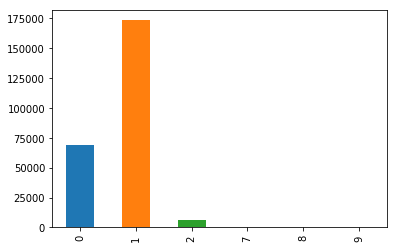

In [502]:
target_variable = "HEARTATTEV"
candidate_variables = []
data[target_variable].value_counts().sort_index().plot("bar");

In [503]:
data[target_variable].isna().sum()

0

In [504]:
#binary classification of target variable
#remove all data rows with unknown target variable
data.drop(data[-data[target_variable].isin([1, 2])].index, inplace = True)
data.loc[data[target_variable] == 1,target_variable] = 0
data.loc[data[target_variable] == 2,target_variable] = 1
data = data.reset_index(drop = True)

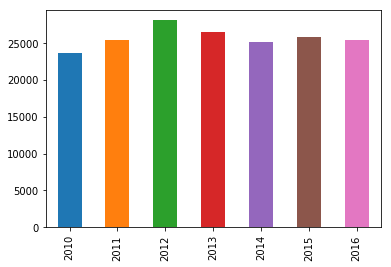

In [505]:
data['YEAR'].value_counts().sort_index().plot(kind='bar');

In [506]:
data["YEAR"].isna().sum()

0

In [507]:
candidate_variables.extend(["YEAR"])

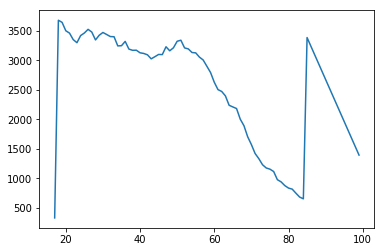

In [508]:
data['AGE'].value_counts().sort_index().plot(kind='line');

In [509]:
#All ages above 85 are regrouped in 85
#Unknowns are coded as 99
data.loc[data['AGE'].isin([96, 97, 98, 99]),'AGE'] = np.nan

#BIRTHYR is treated in the same way. Keep AGE
candidate_variables.extend(["AGE"])

In [510]:
data["AGE"].isna().sum()

1395

In [511]:
#PERWEIGHT technical variable to reweight samples 
data["PERWEIGHT"].describe()

count    179785.000000
mean       9416.623627
std        8351.204369
min           0.000000
25%        3784.611328
50%        6900.357910
75%       12644.689453
max      102133.750000
Name: PERWEIGHT, dtype: float64

In [512]:
data['SEX'].unique()

array([1, 2], dtype=int64)

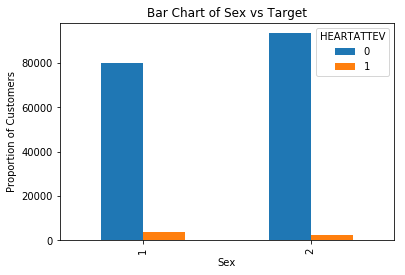

In [513]:
pd.crosstab(data.SEX,data[target_variable]).plot(kind='bar')
plt.title('Bar Chart of Sex vs Target')
plt.xlabel('Sex')
plt.ylabel('Proportion of Customers')
plt.savefig('sex_vs_tgt')

In [514]:
data["SEX"].isna().sum()

0

In [515]:
candidate_variables.extend(["SEX"])

In [516]:
data['MARSTAT'].dtype

dtype('int64')

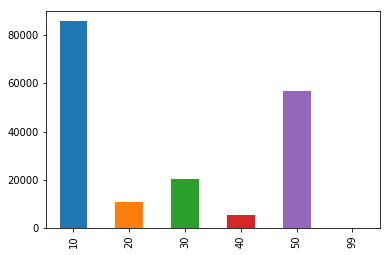

In [517]:
data['MARSTAT'] = data['MARSTAT'].astype('object')
data['MARSTAT'].value_counts().sort_index().plot("bar");

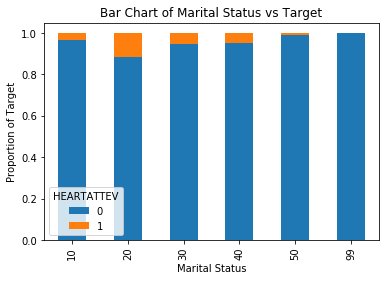

In [518]:
table=pd.crosstab(data.MARSTAT,data[target_variable])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Bar Chart of Marital Status vs Target')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Target')
plt.savefig('marital_vs_tgt')

In [519]:
data["MARSTAT"].isna().sum()

0

In [520]:
candidate_variables.extend(["MARSTAT"])

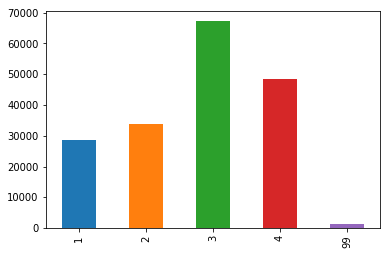

In [521]:
data.loc[data['REGIONMEPS'] == 0, "REGIONMEPS"] = 99
data['REGIONMEPS'] = data['REGIONMEPS'].astype('object')
data['REGIONMEPS'].value_counts().sort_index().plot("bar");

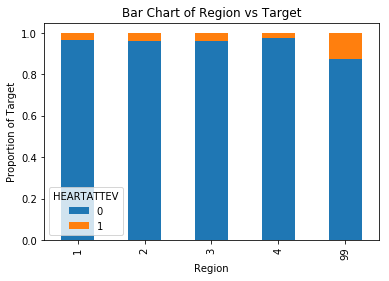

In [522]:
table=pd.crosstab(data.REGIONMEPS,data[target_variable])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Bar Chart of Region vs Target')
plt.xlabel('Region')
plt.ylabel('Proportion of Target')
plt.savefig('region_vs_tgt')

In [523]:
candidate_variables.extend(["REGIONMEPS"])

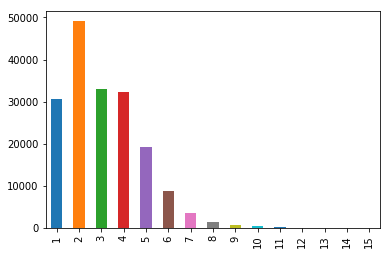

In [524]:
data['FAMSIZE'].value_counts().sort_index().plot("bar");

In [525]:
data["FAMSIZE"].isna().sum()

0

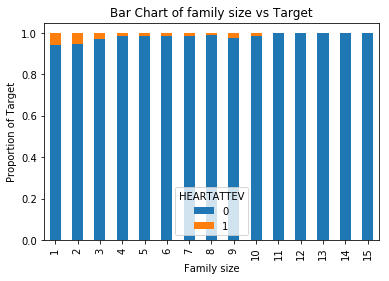

In [526]:
table=pd.crosstab(data.FAMSIZE,data[target_variable])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Bar Chart of family size vs Target')
plt.xlabel('Family size')
plt.ylabel('Proportion of Target')
plt.savefig('famsize_vs_tgt')

In [527]:
candidate_variables.extend(["FAMSIZE"])

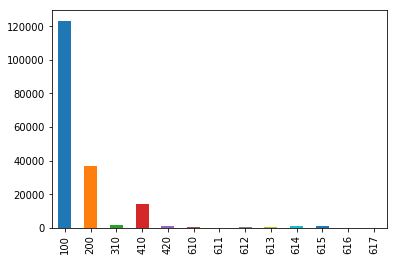

In [528]:
data['RACEA'] = data['RACEA'].astype('object')
data['RACEA'].value_counts().sort_index().plot("bar");

In [529]:
data["RACEA"].isna().sum()

0

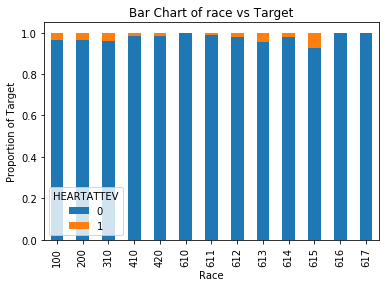

In [530]:
table=pd.crosstab(data.RACEA,data[target_variable])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Bar Chart of race vs Target')
plt.xlabel('Race')
plt.ylabel('Proportion of Target')
plt.savefig('race_vs_tgt')

In [531]:
data.loc[~data['RACEA'].isin([100, 200, 310, 410, 614, 615]),'RACEA'] = 999
data['RACEA'] = data['RACEA'].astype('object')

In [532]:
candidate_variables.extend(["RACEA"])

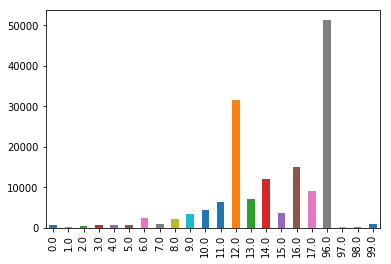

In [533]:
data['EDUCYR'].value_counts().sort_index().plot("bar");
#review if correlation high enough to just use one of two

In [534]:
data["EDUCYR"].isna().sum()

26499

In [535]:
# regroup different types of unknown. Treat variable as numeric therefore keep as missing
# integer variable canont handle empty, keep as float
data.loc[data['EDUCYR'].isin([96, 97, 98, 99]),'EDUCYR'] = np.nan

In [536]:
data["EDUCYR"].isna().sum()

79035

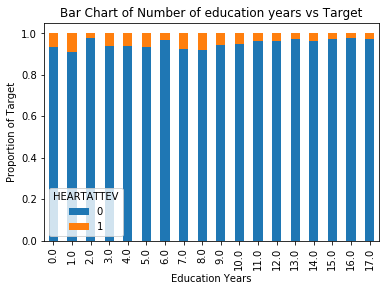

In [537]:
table=pd.crosstab(data.EDUCYR,data[target_variable])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Bar Chart of Number of education years vs Target')
plt.xlabel('Education Years')
plt.ylabel('Proportion of Target')
plt.savefig('educyr_vs_tgt')

In [538]:
candidate_variables.extend(["EDUCYR"])

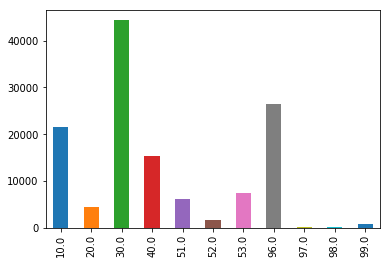

In [539]:
data['HIDEG'].value_counts().sort_index().plot("bar");

In [540]:
data["HIDEG"].isna().sum()

51560

In [541]:
# regroup different types of unknown. Treat as categorical variable, therefore replace with 99
data.loc[data['HIDEG'].isna(), 'HIDEG'] = 99
data['HIDEG'] = data['HIDEG'].astype(int)
data.loc[data['HIDEG'].isin([96, 97, 98, 99]),'HIDEG'] = 99
data['HIDEG'] = data['HIDEG'].astype('object')

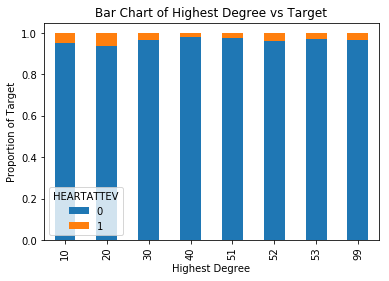

In [542]:
table=pd.crosstab(data.HIDEG,data[target_variable])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Bar Chart of Highest Degree vs Target')
plt.xlabel('Highest Degree')
plt.ylabel('Proportion of Target')
plt.savefig('hideg_vs_tgt')

In [543]:
data["HIDEG"].isna().sum()

0

In [544]:
candidate_variables.extend(["HIDEG"])

In [545]:
data["INCTOT"].describe()

count    179785.000000
mean      29824.530645
std       33950.942183
min     -204643.000000
25%        8088.000000
50%       20000.000000
75%       40000.000000
max      731652.960000
Name: INCTOT, dtype: float64

In [546]:
data["INCTOT"].isna().sum()

0

In [547]:
data["FTOTVAL"].describe()

count    179785.000000
mean      61156.177518
std       57114.272213
min     -258220.000000
25%       21855.000000
50%       45000.000000
75%       82930.000000
max      731653.000000
Name: FTOTVAL, dtype: float64

In [548]:
data["FTOTVAL"].isna().sum()

0

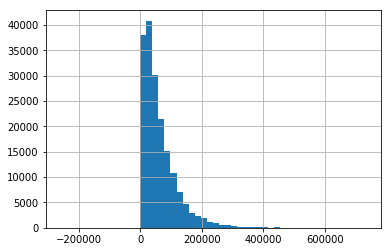

In [549]:
data["FTOTVAL"].hist(bins=50);

In [550]:
data.loc[data["FTOTVAL"]<-10000, "FTOTVAL"].size

35

In [551]:
#only few outliers with large negative total value. Limit to -10000
data.loc[data["FTOTVAL"]<-10000, "FTOTVAL"] = -10000

In [552]:
candidate_variables.extend(["FTOTVAL"])

In [553]:
data['DIABETICEV'].value_counts()

1    160998
2     18755
9        27
7         5
Name: DIABETICEV, dtype: int64

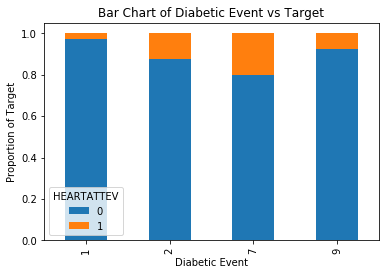

In [554]:
table=pd.crosstab(data.DIABETICEV,data[target_variable])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Bar Chart of Diabetic Event vs Target')
plt.xlabel('Diabetic Event')
plt.ylabel('Proportion of Target')
plt.savefig('hideg_vs_tgt')

In [555]:
data.loc[data['DIABETICEV'].isin([1, 7, 9]),'DIABETICEV'] = 0
data.loc[data['DIABETICEV'] == 2,'DIABETICEV'] = 1

In [556]:
data["DIABETICEV"].isna().sum()

0

In [557]:
candidate_variables.extend(["DIABETICEV"])

In [558]:
candidate_variables
#candidate_variables = ['YEAR', 'PERWEIGHT', 'SAQWEIGHT', 'AGE', 'SEX', 'MARSTAT', 'EDUCYR', 'HIDEG', 'INCTOT', 'FTOTVAL', 'DIABETICEV']

['YEAR',
 'AGE',
 'SEX',
 'MARSTAT',
 'REGIONMEPS',
 'FAMSIZE',
 'RACEA',
 'EDUCYR',
 'HIDEG',
 'FTOTVAL',
 'DIABETICEV']

In [559]:
pig_tables = {}
for variable in candidate_variables:
    # Create a predictor insight graph table
    pig_table = create_pig_table(data, target_variable, variable)
    # Add the table to the dictionary
    pig_tables[variable] = pig_table

C:\Users\Karsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


In [560]:
print(pig_tables["DIABETICEV"])

   DIABETICEV  Incidence    Size
0           0   0.024958  161030
1           1   0.123167   18755


In [561]:
print(pig_tables["YEAR"])

   YEAR  Incidence   Size
0  2010   0.035634  23629
1  2011   0.034940  25415
2  2012   0.032953  28040
3  2013   0.034152  26499
4  2014   0.035394  25061
5  2015   0.036001  25749
6  2016   0.037650  25392


In [562]:
print(pig_tables["SEX"])

   SEX  Incidence   Size
0    1   0.044926  83783
1    2   0.026718  96002


In [563]:
print(pig_tables["REGIONMEPS"])

   REGIONMEPS  Incidence   Size
0           1   0.033597  28693
1           2   0.039601  33787
2           3   0.038850  67311
3           4   0.025474  48599
4          99   0.124731   1395


In [564]:
print(pig_tables["FAMSIZE"])

    FAMSIZE  Incidence   Size
0         1   0.058238  30564
1         2   0.053452  49166
2         3   0.027479  33044
3         4   0.015122  32403
4         5   0.014596  19321
5         6   0.016742   8840
6         7   0.016412   3595
7         8   0.008005   1499
8         9   0.025848    619
9        10   0.014563    412
10       11   0.000000    162
11       12   0.000000     58
12       13   0.000000     48
13       14   0.000000     47
14       15   0.000000      7


In [565]:
print(pig_tables["RACEA"])

   RACEA  Incidence    Size
0    100   0.037193  123355
1    200   0.035741   36513
2    310   0.042244    1515
3    410   0.015165   13848
4    614   0.020426    1126
5    615   0.072800    1250
6    999   0.022039    2178


In [566]:
train = data[candidate_variables]
Label = data[target_variable]

In [567]:
train.shape

(179785, 11)

In [568]:
cat_features = [train.columns[i] for i, j in enumerate(train.dtypes) if (j == "object" or j == "bool")]
numeric_features = [train.columns[i] for i, j in enumerate(train.dtypes) if j in ["int64", "float64"]]

In [569]:
cat_features

['MARSTAT', 'REGIONMEPS', 'RACEA', 'HIDEG']

In [570]:
numeric_features

['YEAR', 'AGE', 'SEX', 'FAMSIZE', 'EDUCYR', 'FTOTVAL', 'DIABETICEV']

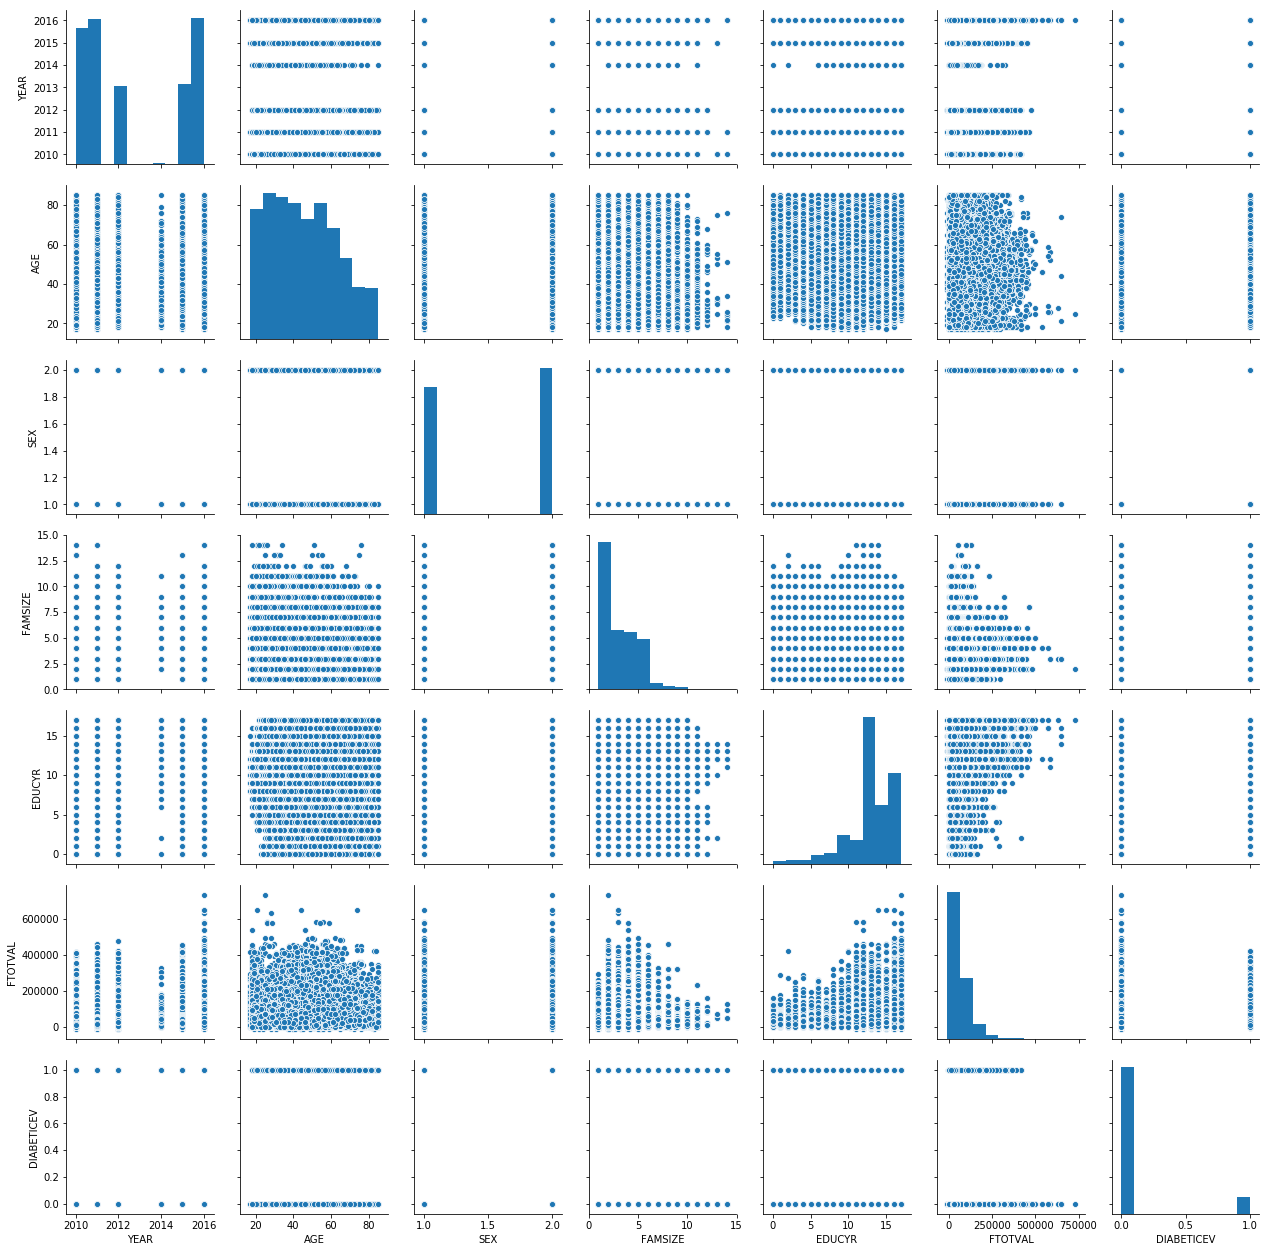

In [571]:
import seaborn as sns
sns.pairplot(data[numeric_features].dropna());

# Dummy variables

In [572]:
train_cat = train[cat_features]
for var in cat_features:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(train_cat[var], prefix=var)
    data1=train_cat.join(cat_list)
    train_cat=data1
train_cat.head()

,MARSTAT,REGIONMEPS,RACEA,HIDEG,MARSTAT_10,MARSTAT_20,MARSTAT_30,MARSTAT_40,MARSTAT_50,MARSTAT_99,...,RACEA_615,RACEA_999,HIDEG_10,HIDEG_20,HIDEG_30,HIDEG_40,HIDEG_51,HIDEG_52,HIDEG_53,HIDEG_99
0,10,1,100,53,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,10,1,100,30,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,10,4,999,52,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,10,4,410,51,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,50,1,200,99,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


# Missing values

In [573]:
train_num = train[numeric_features]
# check variables that are missing
for j in range(train_num.values.shape[1]):
    vec = train_num.values[:,j]
    mask = np.isfinite(vec)
    if np.sum(~mask) > 0:
        print(j, train_num.columns[j])
        print(np.sum(~mask))

1 AGE
1395
4 EDUCYR
79035


In [574]:
imp = SimpleImputer(missing_values=np.nan, strategy='median')
imp.fit(train_num)
train_num_imp= imp.transform(train_num)
train_num = pd.DataFrame(train_num_imp, columns = train_num.columns)

In [575]:
train_cat.head()

,MARSTAT,REGIONMEPS,RACEA,HIDEG,MARSTAT_10,MARSTAT_20,MARSTAT_30,MARSTAT_40,MARSTAT_50,MARSTAT_99,...,RACEA_615,RACEA_999,HIDEG_10,HIDEG_20,HIDEG_30,HIDEG_40,HIDEG_51,HIDEG_52,HIDEG_53,HIDEG_99
0,10,1,100,53,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,10,1,100,30,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,10,4,999,52,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,10,4,410,51,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,50,1,200,99,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


# Dataset

In [576]:
train = pd.concat([train_num, train_cat], axis=1, sort=True)
train = train.drop(['MARSTAT', 'HIDEG', 'REGIONMEPS', 'RACEA'], axis=1)

# Train-test

In [577]:
X_train, X_test, y_train, y_test = train_test_split(train, Label, random_state=0)

In [578]:
y_train.value_counts().sort_index()

0    130168
1      4670
Name: HEARTATTEV, dtype: int64

In [579]:
y_test.value_counts().sort_index()

0    43288
1     1659
Name: HEARTATTEV, dtype: int64

# K-fold

In [580]:
num_folds = 5
seed = 7

kfold = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)

# Logistic Regression - Forward selection

In [581]:
# remove one category (null)
X_train_LR = X_train.drop(['MARSTAT_99', 'HIDEG_99', 'REGIONMEPS_99', 'RACEA_999'], axis=1)
X_test_LR = X_test.drop(['MARSTAT_99', 'HIDEG_99', 'REGIONMEPS_99', 'RACEA_999'], axis=1)
basetable = pd.concat([X_train_LR, y_train], axis=1)
variables = list(X_train_LR.columns.values)

In [582]:
basetable.head()

,YEAR,AGE,SEX,FAMSIZE,EDUCYR,FTOTVAL,DIABETICEV,MARSTAT_10,MARSTAT_20,MARSTAT_30,...,RACEA_614,RACEA_615,HIDEG_10,HIDEG_20,HIDEG_30,HIDEG_40,HIDEG_51,HIDEG_52,HIDEG_53,HEARTATTEV
87489,2013.0,23.0,1.0,3.0,12.0,1500.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
71069,2012.0,23.0,2.0,2.0,12.0,21000.0,0.0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
121339,2014.0,60.0,2.0,2.0,12.0,45488.0,0.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
43066,2011.0,38.0,1.0,1.0,13.0,26030.0,0.0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
160043,2016.0,69.0,2.0,1.0,6.0,29910.0,1.0,0,1,0,...,0,0,1,0,0,0,0,0,0,0


In [583]:
max_number_variables = 6
number_iterations = min(max_number_variables, len(variables))
current_variables = []
for i in range(0,number_iterations):
    next_var = next_best(current_variables, variables, [target_variable], basetable)
    current_variables = current_variables + [next_var]
    variables.remove(next_var)
print(current_variables)

0.12927989156858594
0.1259125561457703
0.12416957628172752
0.12355591137340295
0.12334148319174451
0.12314416340441657
['AGE', 'DIABETICEV', 'SEX', 'RACEA_410', 'FAMSIZE', 'HIDEG_20']


In [586]:
logreg = linear_model.LogisticRegression(solver='lbfgs', max_iter = 200)

In [587]:
logreg.fit(basetable[current_variables],basetable[target_variable])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [588]:
predictions_train = logreg.predict_proba(X_train_LR[current_variables])
predictions_test = logreg.predict_proba(X_test_LR[current_variables])
print("Train AUC: ", roc_auc_score(y_train, predictions_train[:,1]))
print("Train logloss: ", log_loss(y_train, predictions_train[:,1]))
print("Test AUC: ", roc_auc_score(y_test, predictions_test[:,1]))
print("Test logloss: ", log_loss(y_test, predictions_test[:,1]))

Train AUC:  0.8408493612668826
Train logloss:  0.12314416340441657
Test AUC:  0.8442278646438188
Test logloss:  0.1284876982369677


C:\Users\Karsten\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


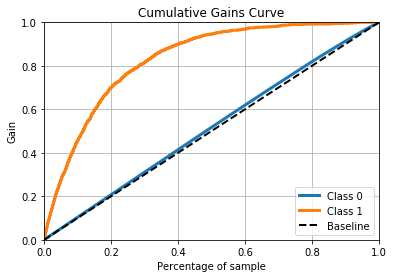

In [589]:
skplt.metrics.plot_cumulative_gain(y_test, predictions_test)
plt.show()

In [590]:
np.exp(logreg.coef_)

array([[1.06226524, 2.82707163, 0.50425056, 0.41970432, 0.9173651 ,
        1.8518119 ]])

In [592]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,basetable[current_variables])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.139886
         Iterations 9
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.071     
Dependent Variable: HEARTATTEV       AIC:              37735.8293
Date:               2018-10-27 18:12 BIC:              37794.7003
No. Observations:   134838           Log-Likelihood:   -18862.   
Df Model:           5                LL-Null:          -20293.   
Df Residuals:       134832           LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     9.0000                                       
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
AGE           0.0121    0.0007   18.2162  0.0000   0.0108   0.0134
DIABETICEV    1.2039    0.0339   35.4825  0.0000   1.1374   1.

In [593]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, logreg.predict(X_test[current_variables]))
print(confusion_matrix)

[[43284     4]
 [ 1655     4]]


# Logistic Regression - Grid search

In [594]:
param_grid_logreg = {
    'C': [1, 10, 100]
}

In [595]:
logreg2 = linear_model.LogisticRegression(penalty = 'l1', solver='liblinear') #'lbfgs')
grid_logreg = GridSearchCV(logreg2, param_grid_logreg, cv=kfold, scoring='neg_log_loss', error_score='raise')
grid_logreg.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=7, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1, 10, 100]}, pre_dispatch='2*n_jobs', refit=True,
       return_train_score='warn', scoring='neg_log_loss', verbose=0)

In [596]:
means = grid_logreg.cv_results_['mean_test_score']
stds = grid_logreg.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_logreg.cv_results_['params']):
   print("%0.5f (+/-%0.05f) for %r"
   % (mean, std * 2, params))

-0.12069 (+/-0.00146) for {'C': 1}
-0.12070 (+/-0.00147) for {'C': 10}
-0.12070 (+/-0.00145) for {'C': 100}


In [597]:
grid_logreg.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [598]:
predictions_train = grid_logreg.predict_proba(X_train)
predictions_test = grid_logreg.predict_proba(X_test)
print("Train AUC: ", roc_auc_score(y_train, predictions_train[:,1]))
print("Train logloss: ", log_loss(y_train, predictions_train[:,1]))
print("Test AUC: ", roc_auc_score(y_test, predictions_test[:,1]))
print("Test logloss: ", log_loss(y_test, predictions_test[:,1]))

Train AUC:  0.8537427015747858
Train logloss:  0.12048410508087229
Test AUC:  0.853445248438511
Test logloss:  0.12630906651207552


In [599]:
np.exp(grid_logreg.best_estimator_.coef_)

array([[0.99975342, 1.0614444 , 0.47141466, 0.96086358, 1.02316993,
        0.99999512, 2.6136705 , 0.67882399, 0.74083971, 0.78762443,
        1.        , 0.47522618, 1.        , 0.25481552, 0.29098589,
        0.28075738, 0.22516949, 1.81988574, 0.68601803, 0.60471   ,
        1.        , 0.34159588, 0.72352747, 1.32350545, 0.6955597 ,
        0.60980999, 0.87576637, 0.50717839, 0.34881259, 0.33102607,
        0.49552819, 0.51021062, 0.51598377]])

In [268]:
#grid_logreg.best_estimator_.coef_ @ train[10] + grid_logreg.best_estimator_.intercept_